Maybe we define new structure which captures the input parameters specific to each problem in one place (`scale_factor`).
We need to define a range on `d` that is also function dependent (that we could adjust by hand). 

We need to generate three graphs: 
- Histogram of Number of `loc_min` points were found, (so outputs of the Optim routine) and what percentage of them is within a small distance of a critical point of the approximant. As a function of the degree `d` of the approximant.


In [1]:
using Pkg
using Revise 
Pkg.activate("../../.")
using Globtim
using DynamicPolynomials, DataFrames
using ProgressLogging
using Optim
using Distributions
using CairoMakie
CairoMakie.activate!

  Activating project at `~/globtim`


activate! (generic function with 1 method)

The Noisy Deuflhard example needs to emphasize the robustness of our method to a (nice) noise perturbation. 
- []: what is the magnitude of the noise --> standard deviation of ? 
- []: what are we plotting? The 3 graphs with respect to the true location of the critical points. (Take Chebfun2 outputs?) 
- []: are we just repeating the plots from noiseless case? let's do them separate -- maybe blue-yellow color scheme for noisy histograms.

In [2]:
params = load_function_params("Deuflhard")
TR_0 = test_input(Deuflhard;
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=params.tolerance)

@polyvar(x[1:TR_0.dim]); # Define polynomial ring 

In [3]:
d = 12 # Initial Degree 

pol_cheb = Constructor(TR_0, d, basis=:chebyshev);
df_cheb = solve_and_parse(pol_cheb, x, TR_0.objective, TR_0)
df_cheb, df_min_cheb = analyze_critical_points(TR_0.objective, df_cheb, TR_0, tol_dist=0.005)

current L2-norm: 0.33513561513657436
Dimension m of the vector space: 91

=== Starting MSolve Parser (dimension: 2) ===
Processed 13 points (0.001s)
Processing point 1 of 13
Optimization has converged within bounds: ✓
Processing point 2 of 13
Optimization has converged within bounds: ✓
Processing point 3 of 13
Optimization has converged within bounds: ✓
Processing point 4 of 13
Optimization has converged within bounds: ✓
Processing point 5 of 13
Optimization has converged within bounds: ✓
Processing point 6 of 13
Optimization has converged within bounds: ✓
Processing point 7 of 13
Optimization has converged within bounds: ✓
Processing point 8 of 13
Optimization has converged within bounds: ✓
Processing point 9 of 13
Optimization has converged within bounds: ✓
Processing point 10 of 13
Optimization has converged within bounds: ✓
Processing point 11 of 13
Optimization has converged within bounds: ✓
Processing point 12 of 13
Optimization has converged within bounds: ✓
Processing point 13 

(13×8 DataFrame
 Row │ x1            x2            z           y1            y2            clo ⋯
     │ Float64       Float64       Float64     Float64       Float64       Boo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.27905      -1.01273      0.00572107   0.256625     -1.01625      fal ⋯
   2 │  0.489134     -0.925659     0.28048      0.256625     -1.01625      fal
   3 │  0.745638     -0.745638     0.00162271   0.741152     -0.741152     fal
   4 │  0.925659     -0.489134     0.28048      1.01625      -0.256625     fal
   5 │ -0.419202     -0.419202     2.55639     -0.459896     -0.459896     fal ⋯
   6 │  1.01273      -0.27905      0.00572107   1.01625      -0.256625     fal
   7 │ -2.62669e-16   3.91878e-15  4.0         -2.62669e-16   3.91878e-15   tr
   8 │ -1.01273       0.27905      0.00572107  -1.01625       0.256625     fal
   9 │  0.419202      0.419202     2.55639      0.459896      0.459896     fal ⋯
  10 │ -0.925659      0.

Check that `df_min_cheb` does actually contain ONLY the 6 local minimizers ? Copy by hand if needed --> we need them as reference values for the critical noisy points.

In [34]:
function noisy_Deuflhard(xx::AbstractVector; mean::Float64=0.0, stddev::Float64=5.0)::Float64
    noise = rand(Normal(mean, stddev))
    return Deuflhard(xx) + noise
end


# Generate test inputs with different noise levels
TR1 = test_input(xx -> noisy_Deuflhard(xx, mean=0.0, stddev=1.0);
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=0.1)

TR2 = test_input(xx -> noisy_Deuflhard(xx, mean=0.0, stddev=2.0);
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=0.1)

TR3 = test_input(xx -> noisy_Deuflhard(xx, mean=0.0, stddev=3.0);
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=0.1)

TR4 = test_input(xx -> noisy_Deuflhard(xx, mean=0.0, stddev=4.0);
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=0.1)

TR5 = test_input(xx -> noisy_Deuflhard(xx, mean=0.0, stddev=5.0);
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
    tolerance=0.1)

test_input(2, [0.0, 0.0], 120, (0.1, 0.5), 0.1, (0.0, 0.0), 1.2, 1.0, 6, var"#41#42"())

In [5]:
d_min, d_max = 3, 20

(3, 20)

In [12]:
results1 = analyze_degrees(TR1, x, d_min, d_max, step=1, tol_dist=0.1)
results2 = analyze_degrees(TR2, x, d_min, d_max, step=1, tol_dist=0.1)
results3 = analyze_degrees(TR3, x, d_min, d_max, step=1, tol_dist=0.1)
results4 = analyze_degrees(TR4, x, d_min, d_max, step=1, tol_dist=0.1)
results5 = analyze_degrees(TR5, x, d_min, d_max, step=1, tol_dist=0.1)

current L2-norm: 42.89557154703444
Dimension m of the vector space: 10

=== Starting MSolve Parser (dimension: 2) ===
Processed 4 points (0.0s)
Processing point 1 of 1
Optimization status: ✗ (did not converge)
current L2-norm: 22.8561761570478
Dimension m of the vector space: 15

=== Starting MSolve Parser (dimension: 2) ===
Processed 9 points (0.0s)
Processing point 1 of 9
Optimization has converged within bounds: ✓
Processing point 2 of 9
Optimization has converged within bounds: ✓
Processing point 3 of 9
Optimization status: ✗ (did not converge)
Processing point 4 of 9
Optimization has converged within bounds: ✓
Processing point 5 of 9
Optimization status: ✗ (outside bounds)
Processing point 6 of 9
Optimization has converged within bounds: ✓
Processing point 7 of 9
Optimization has converged within bounds: ✓
Processing point 8 of 9
Optimization status: ✗ (did not converge)
Processing point 9 of 9
Optimization status: ✗ (did not converge)
current L2-norm: 22.917528046231123
Dimension

Dict{Int64, @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTuple, discrete_l2::Float64}} with 18 entries:
  5  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  16 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  20 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  12 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  8  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  17 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  19 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  6  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  11 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  9  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  14 => @NamedTuple{df::DataFrame, df_min::DataFrame, converg

In [51]:
function five_plotdiscretel2(all_results, start_degree::Int, end_degree::Int, step::Int; show_legend::Bool=false)
    degrees = start_degree:step:end_degree

    colors = [:red, :darkblue, :darkgreen, :purple, :darkorange]
    

    fig = Figure(size=(800, 400))

    ax = Axis(fig[1, 1],
        title="Discrete L2 Norm Comparison",
        xlabel="Degree")

    for (i, results) in enumerate(all_results)
        l2_norms = Float64[]

        for d in degrees
            push!(l2_norms, results[d].discrete_l2)
        end

        scatterlines!(ax, degrees, l2_norms,
            color=colors[i],
            markersize=8,
            linewidth=2,
            label=show_legend ? "Noise level $i" : nothing)
    end

    if show_legend
        axislegend(ax, position=:rt)
    end

    return fig
end

five_plotdiscretel2 (generic function with 1 method)

In [15]:
results = [results1, results2, results3, results4, results5];

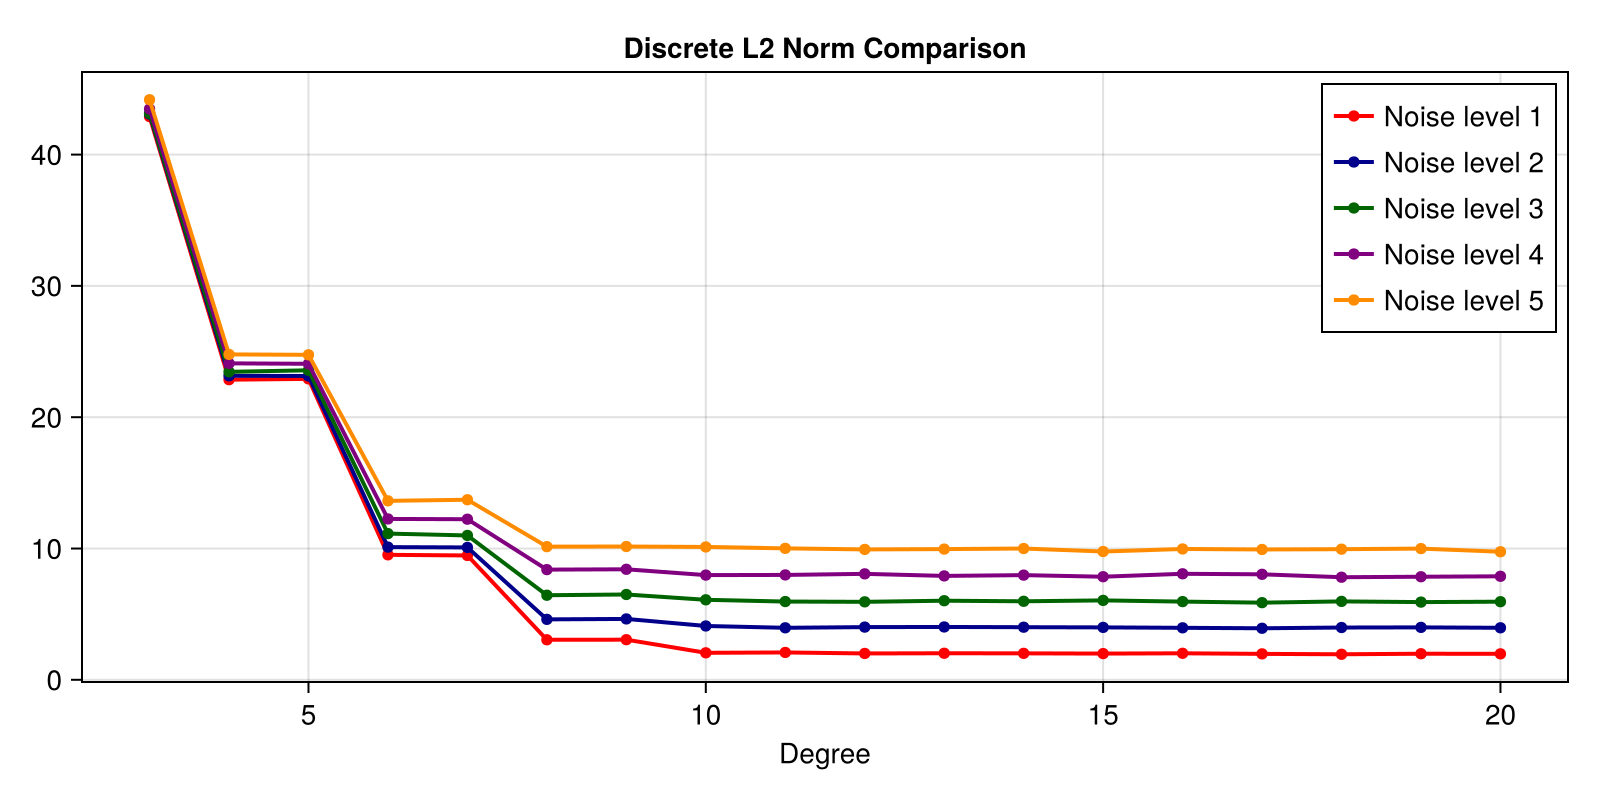

CairoMakie.Screen{IMAGE}


In [52]:
fig_1 = five_plotdiscretel2(results, d_min, d_max, 1, show_legend=true)
save("discrete_l2_5_noises.pdf", fig_1)
display(fig_1)

In [32]:
function five_capture_histogram(all_results, start_degree::Int, end_degree::Int, step::Int;
    tol_dist::Float64=0.001, show_legend::Bool=false)

    degrees = start_degree:step:end_degree

    # Adjust figure size based on whether legend is shown
    fig_width = show_legend ? 1000 : 800
    fig = Figure(size=(fig_width, 600))

    ax = Axis(fig[1, 1],
        xlabel="Polynomial Degree",
        titlesize=20,
        xlabelsize=14,
        ylabelsize=14)

    positions = collect(degrees)
    bar_width = 0.15  # Width for each bar in the group

    # Colors for each iteration
    colors = [
        (:forestgreen, 0.8),
        (:darkblue, 0.8),
        (:purple, 0.8),
        (:darkred, 0.8),
        (:darkorange, 0.8)
    ]

    # Plot for each result set
    for (i, results) in enumerate(all_results)
        total_mins = Int[]
        uncaptured_mins = Int[]

        for d in degrees
            df_min = results[d][2]
            push!(total_mins, nrow(df_min))
            push!(uncaptured_mins, count(.!df_min.captured))
        end

        # Calculate offset positions for this iteration
        # Center the group of bars by subtracting 2 from i
        offset_positions = [p + (i - 3) * bar_width for p in positions]

        # Plot bars for this iteration
        barplot!(ax, offset_positions, total_mins,
            width=bar_width,
            color=(colors[i][1], 0.3),  # Light version for total
            label=show_legend ? "Total mins $i" : nothing)

        barplot!(ax, offset_positions, uncaptured_mins,
            width=bar_width,
            color=colors[i],  # Dark version for uncaptured
            label=show_legend ? "Uncaptured $i" : nothing)
    end

    # Set x-axis ticks to show degrees at center positions
    ax.xticks = (positions, string.(degrees))
    ax.xticklabelsize = 12
    ax.yticklabelsize = 12

    if show_legend
        Legend(fig[1, 2],
            ax,
            framevisible=true,
            backgroundcolor=(:white, 0.9),
            padding=(10, 10, 10, 10))
        colsize!(fig.layout, 1, Relative(0.8))
        colsize!(fig.layout, 2, Relative(0.2))
    end

    return fig
end

five_capture_histogram (generic function with 1 method)

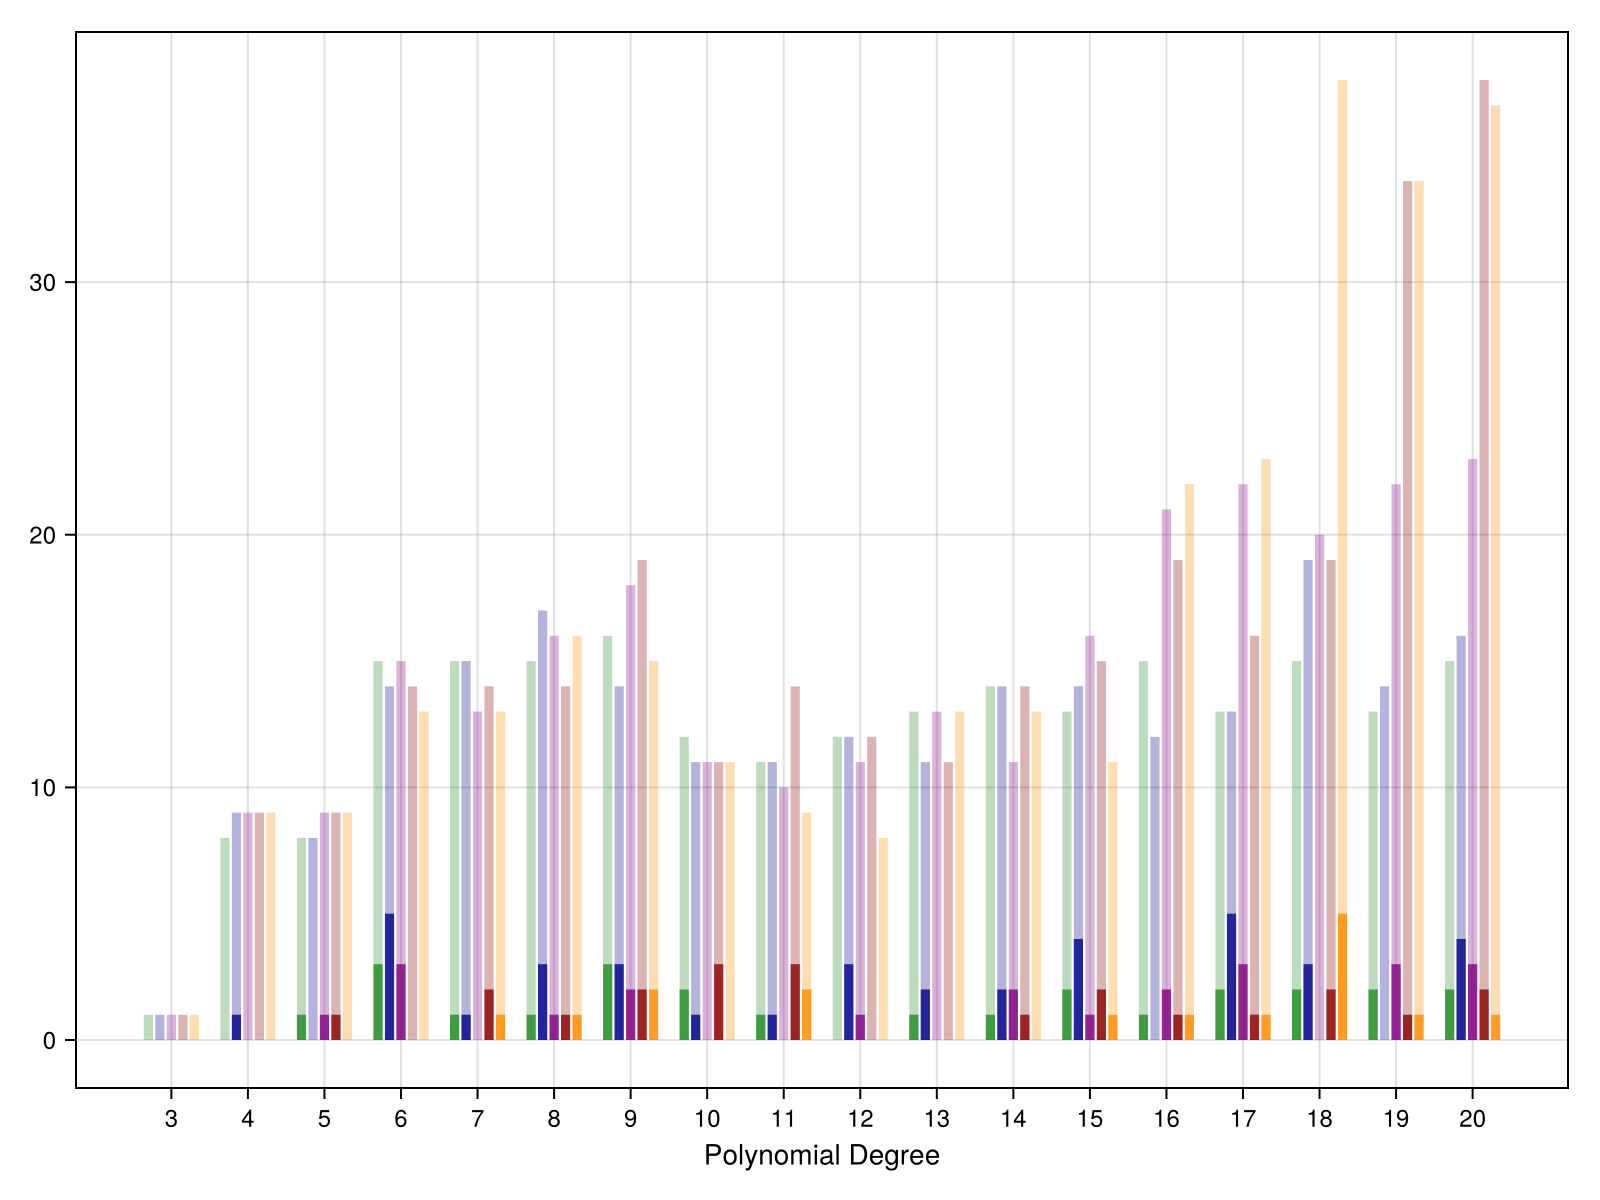

CairoMakie.Screen{IMAGE}


In [33]:
fig_2 = five_capture_histogram(results, d_min, d_max, 1, show_legend=false)
# save("histogram.pdf", fig_2)
display(fig_2)

In [41]:
function five_plot_convergence_analysis(all_results, start_degree::Int, end_degree::Int, step::Int;
    show_legend::Bool=true,
    show_max::Bool=true,
    show_avg::Bool=true)

    degrees = start_degree:step:end_degree

    # Colors for maximum distances
    max_colors = [
        :red,
        :darkblue,
        :darkgreen,
        :purple,
        :darkorange
    ]

    # Colors for average distances
    avg_colors = [
        :red,
        :darkblue,
        :darkgreen,
        :purple,
        :darkorange
    ]

    fig = Figure(size=(600, 400))

    ax = Axis(fig[1, 1],
        title="Distance to Nearest Critical Point",
        xlabel="Degree")

    # Plot for each result set
    for (i, results) in enumerate(all_results)
        max_distances = Float64[]
        avg_distances = Float64[]

        for d in degrees
            df = results[d].df
            stats = analyze_convergence_distances(df)
            push!(max_distances, stats.maximum)
            push!(avg_distances, stats.average)
        end

        if show_max
            scatterlines!(ax, degrees, max_distances,
                label=show_legend ? "Maximum $i" : nothing,
                color=max_colors[i])
        end

        if show_avg
            scatterlines!(ax, degrees, avg_distances,
                label=show_legend ? "Average $i" : nothing,
                color=avg_colors[i])
        end
    end

    if show_legend
        axislegend(ax)
    end

    return fig
end

five_plot_convergence_analysis (generic function with 1 method)

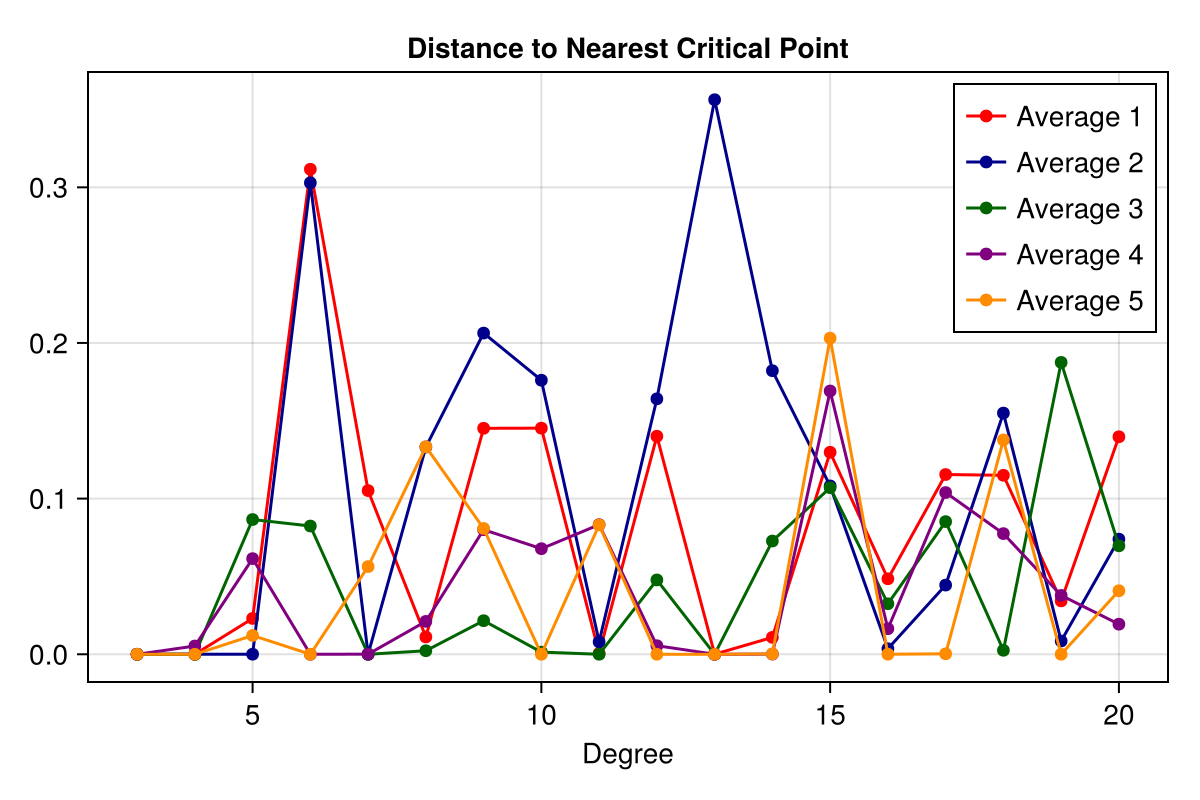

CairoMakie.Screen{IMAGE}


In [42]:
fig_3 = five_plot_convergence_analysis(results, d_min, d_max, 1, show_max=false)
# save("convergence_analysis.pdf", fig_3)
display(fig_3)

In [48]:
using Printf  # Add this at the top
using LinearAlgebra

function five_plot_filtered_y_distances(
    all_df_filtered::Vector{DataFrame},
    all_results::Vector{Dict{Int,NamedTuple{(:df, :df_min, :convergence_stats, :discrete_l2),
        Tuple{DataFrame,DataFrame,NamedTuple,Float64}}}},
    start_degree::Int,
    end_degree::Int,
    step::Int=1;
    use_optimized::Bool=true,
    show_legend::Bool=true,
    show_max::Bool=true,
    show_avg::Bool=true)

    degrees = start_degree:step:end_degree

    # Colors 
    max_colors = [:red, :darkblue, :darkgreen, :purple, :darkorange]
    avg_colors = [:red, :darkblue, :darkgreen, :purple, :darkorange]

    # Print summary table header
    n_dims = count(col -> startswith(string(col), "x"), names(all_df_filtered[1]))
    point_type = use_optimized ? "optimized (y)" : "initial (x)"

    println("\nAnalysis Summary:")
    println("• Dimensions: $n_dims")
    println("• Using $point_type points")
    println("• Degrees: $start_degree to $end_degree (step $step)\n")

    # Table header
    println("Iteration | Points | Max Dist | Min Dist | Avg Dist")
    println("-"^50)

    # Store all distances for plotting
    all_max_distances = Vector{Vector{Float64}}()
    all_avg_distances = Vector{Vector{Float64}}()

    # Process each dataset
    for (iter, (df_filtered, results)) in enumerate(zip(all_df_filtered, all_results))
        n_points = nrow(df_filtered)
        point_distances = zeros(Float64, n_points, length(degrees))

        # Calculate distances
        for (i, row) in enumerate(eachrow(df_filtered))
            point_coords = use_optimized ?
                           [row[Symbol("y$j")] for j in 1:n_dims] :
                           [row[Symbol("x$j")] for j in 1:n_dims]

            for (d_idx, d) in enumerate(degrees)
                raw_points = results[d].df
                min_dist = Inf
                for raw_row in eachrow(raw_points)
                    point = [raw_row[Symbol("x$j")] for j in 1:n_dims]
                    dist = norm(point_coords - point)
                    min_dist = min(min_dist, dist)
                end
                point_distances[i, d_idx] = min_dist
            end
        end

        # Calculate statistics
        max_distances = [maximum(point_distances[:, i]) for i in 1:length(degrees)]
        min_distances = [minimum(point_distances[:, i]) for i in 1:length(degrees)]
        avg_distances = [sum(point_distances[:, i]) / n_points for i in 1:length(degrees)]

        push!(all_max_distances, max_distances)
        push!(all_avg_distances, avg_distances)

        # Print table row
        overall_max = maximum(max_distances)
        overall_min = minimum(min_distances)
        overall_avg = sum(avg_distances) / length(avg_distances)

        @printf("%9d | %6d | %8.6f | %8.6f | %8.6f\n",
            iter, n_points, overall_max, overall_min, overall_avg)
    end

    # Create plot
    fig = Figure(size=(600, 400))

    point_label = use_optimized ? "Optimized" : "Initial"
    ax = Axis(fig[1, 1],
        xlabel="Degree",
        ylabel="")

    for i in 1:length(all_max_distances)
        if show_max
            scatterlines!(ax, degrees, all_max_distances[i],
                label=show_legend ? "Maximum $i" : nothing,
                color=max_colors[i])
        end
        if show_avg
            scatterlines!(ax, degrees, all_avg_distances[i],
                label=show_legend ? "Average $i" : nothing,
                color=avg_colors[i])
        end
    end

    if show_legend
        axislegend(ax)
    end

    return fig
end

five_plot_filtered_y_distances (generic function with 2 methods)


Analysis Summary:
• Dimensions: 2
• Using optimized (y) points
• Degrees: 3 to 20 (step 1)

Iteration | Points | Max Dist | Min Dist | Avg Dist
--------------------------------------------------
        1 |     13 | 1.048318 | 0.000077 | 0.163899
        2 |     13 | 1.049234 | 0.000255 | 0.186111
        3 |     13 | 1.049007 | 0.000094 | 0.200079
        4 |     13 | 1.051131 | 0.000302 | 0.203791
        5 |     13 | 1.048392 | 0.000245 | 0.220753


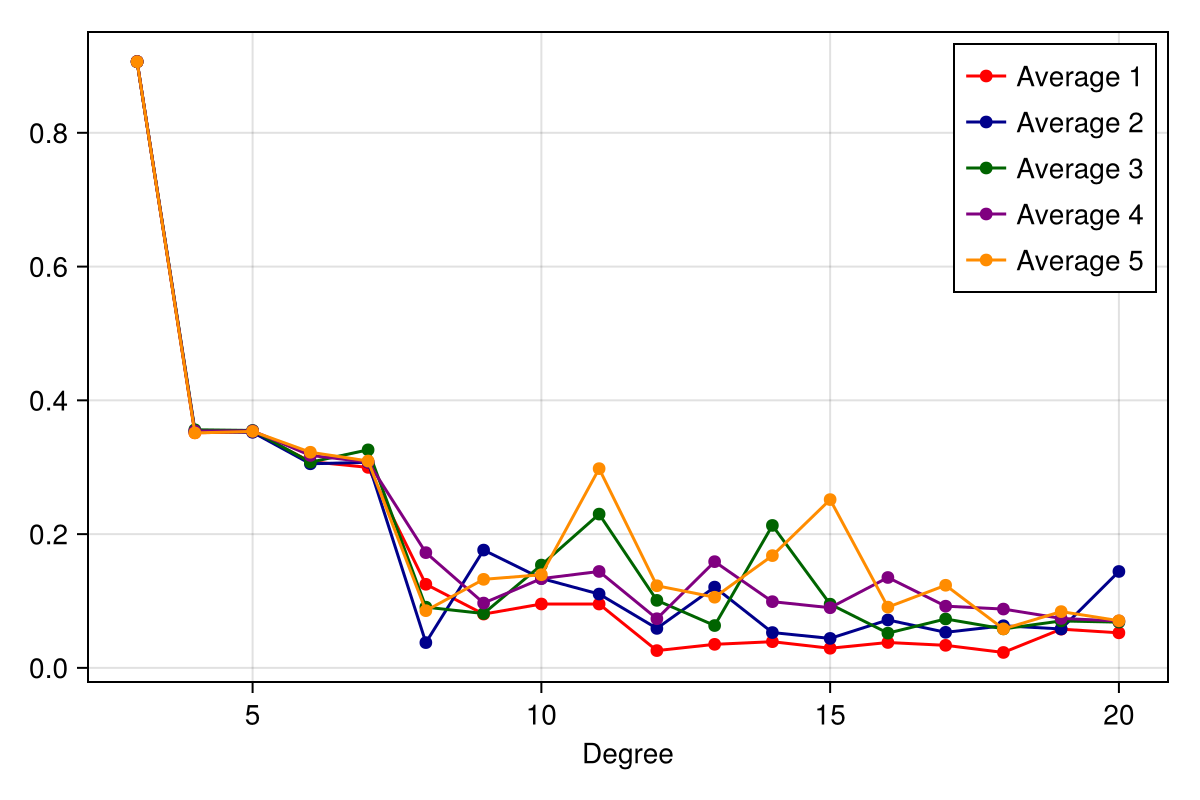

In [49]:
all_df_filtered = [df_cheb, df_cheb, df_cheb, df_cheb, df_cheb]

# Call function with desired options
fig_5 = five_plot_filtered_y_distances(
    all_df_filtered,
    results,
    d_min, d_max, 1,
    show_legend=true,
    show_max=false,
    show_avg=true
)

In [50]:
save("filtered_y_distances_noisy_deufl.pdf", fig_5)

CairoMakie.Screen{PDF}


In [11]:
# fig_6 = plot_filtered_y_distances(df_int, results, d_min, d_max, 1, use_optimized=false)